# Limpeza dos Dados (Cleaning)

In [1]:
# Bibliotecas
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
base_path = "../data/raw/"
# (Recarga rápida para garantir)
df_inad = pd.read_csv(f"{base_path}df_inadimplencia.csv")
df_econ = pd.read_csv(f"{base_path}df_economico.csv")
df_ibge = pd.read_csv(f"{base_path}df_ibge.csv")
df_clima = pd.read_csv(f"{base_path}df_inmet.csv")
df_eventos = pd.read_csv(f"{base_path}df_eventos_politicos.csv")

# Conversão
dfs = [df_inad, df_econ, df_ibge, df_clima, df_eventos]
for df in dfs:
    df["data"] = pd.to_datetime(df["data"], format="%m/%Y")

# Merge
from functools import reduce
df_mestre = reduce(lambda left, right: pd.merge(left, right, on="data", how="outer"), dfs)
df_mestre.set_index("data", inplace=True)
df_mestre = df_mestre.sort_index()
df_mestre = df_mestre["2015-01-01":] # Filtrar data inicial

# LIMPEZA:

# 1. Remover colunas com mais de 30% de nulos
limit_null = len(df_mestre) * 0.30
cols_to_drop = df_mestre.columns[df_mestre.isnull().sum() > limit_null]
print(f"Removendo colunas com muitos nulos: {list(cols_to_drop)}")
df_clean = df_mestre.drop(columns=cols_to_drop)

# 2. Preencher pequenas falhas (Interpolation)
df_clean = df_clean.interpolate(method='time')

# Se ainda sobrar algum nulo nas pontas (primeiro ou último mês), usamos ffill/bfill
df_clean = df_clean.ffill().bfill()

print(f"Nulos restantes: {df_clean.isnull().sum().sum()}")

Removendo colunas com muitos nulos: ['icms_petroleo', 'soja_triturada_expt', 'soja_residuo_expt', 'soja_oleo_expt', 'milho_grao_expt']
Nulos restantes: 0


C:\Users\pedro\AppData\Local\Temp\ipykernel_23544\4007145254.py:30: FutureWarning: DataFrame.interpolate with object dtype is deprecated and will raise in a future version. Call obj.infer_objects(copy=False) before interpolating instead.
  df_clean = df_clean.interpolate(method='time')


In [3]:
# --- ATUALIZAÇÃO DO FEATURE ENGINEERING --- para adicionar sazonalidade


# Carregar o dataset limpo da etapa anterior (antes dos lags)
# Se não tiver salvo, carregue o 'processed/df_modelagem.csv' e remova os lags antigos para refazer limpo
df = pd.read_csv("../data/processed/df_modelagem.csv", index_col="data", parse_dates=True)

# 1. ADICIONAR SAZONALIDADE (Fundamental para Rural e Comércio)
# O modelo Random Forest não sabe que "mês 12" vem depois do "11". 
# Mas saber o número do mês ajuda a pegar padrões de Natal ou Safra.
df['mes'] = df.index.month

# 2. ADICIONAR "SAFRA" (Feature Sintética para o Agro)
# Simplificação: Safra forte no Brasil costuma ser 1º semestre (Soja).
# 1 = Safra, 0 = Entressafra (aprox)
df['periodo_safra'] = df['mes'].apply(lambda x: 1 if x in [2, 3, 4, 5] else 0)

# 3. REFAZER LAGS (Garantir que Dólar esteja presente para o Rural)
# Vamos garantir que estas colunas existam.
features_chave = ['selic', 'dolar_ptax', 'ipca', 'rendimento_medio_mensal_reais']
lags = [3, 6, 12]

# Recalcular lags apenas se não existirem
for col in features_chave:
    if col in df.columns:
        for lag in lags:
            if f"{col}_lag_{lag}" not in df.columns:
                df[f"{col}_lag_{lag}"] = df[col].shift(lag)

df = df.dropna()

# Salvar versão enriquecida para Rural
df.to_csv("../data/processed/df_modelagem_v3.csv")
print("Dataset V3 com Sazonalidade (Safra) salvo!")

Dataset V3 com Sazonalidade (Safra) salvo!


# Criando Variáveis de Defasagem (Lags)

Shape final após Feature Engineering: (120, 48)


,inad_pj_tot,inad_pf_tot,inad_rd_pf_cr_rur_tot,inad_rd_pj_cr_rur_tot,ipca,spread_pf,spread_pj,spread_tot,selic,cdi,...,ipca_lag_12,tx_desocupacao_p14m_pct_lag_3,tx_desocupacao_p14m_pct_lag_6,tx_desocupacao_p14m_pct_lag_12,rendimento_medio_mensal_reais_lag_3,rendimento_medio_mensal_reais_lag_6,rendimento_medio_mensal_reais_lag_12,dolar_ptax_lag_3,dolar_ptax_lag_6,dolar_ptax_lag_12
data,,,,,,,,,,,,,,,,,,,,,
2016-01-01,2.72,4.30,1.96,0.84,1.75,27.66,11.19,19.78,0.052531,0.052484,...,2.50,9.1,9.0,8.0,1792.0,1792.0,1792.0,3.880138,3.223143,2.634229
2016-02-01,2.78,4.30,2.12,0.81,0.39,28.63,11.64,20.56,0.052531,0.052461,...,2.37,9.1,9.0,8.0,1792.0,1792.0,1792.0,3.776460,3.514305,2.816450
2016-03-01,2.85,4.25,2.23,0.82,-0.36,29.80,11.73,21.28,0.052531,0.052461,...,3.36,9.1,9.0,8.0,1792.0,1792.0,1792.0,3.871136,3.906457,3.139477
2016-04-01,3.04,4.30,2.17,0.83,0.69,31.07,11.64,21.99,0.052531,0.052461,...,0.78,11.0,9.1,8.4,1941.0,1792.0,1792.0,4.052350,3.880138,3.043220
2016-05-01,3.17,4.32,2.12,0.84,1.40,31.57,11.67,22.32,0.052531,0.052461,...,1.22,11.0,9.1,8.4,1941.0,1792.0,1792.0,3.973742,3.776460,3.061715


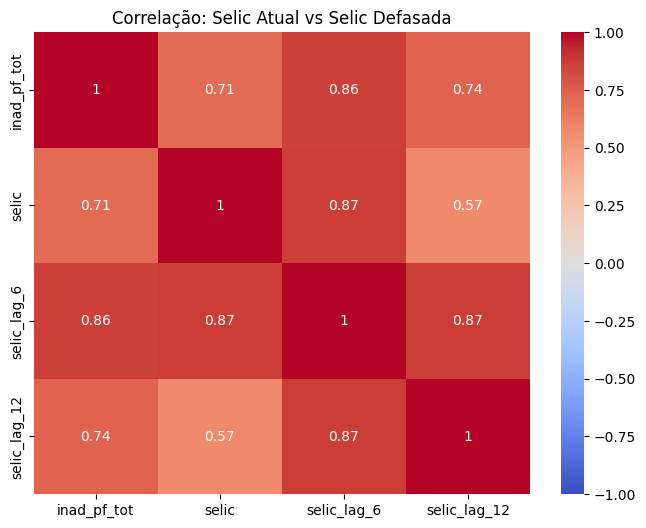

In [4]:
# Lista das variáveis explicativas econômicas que queremos "atrasar"
# Não atrasamos a variável alvo (inadimplência), nem datas, nem dummies fixas
vars_macro = [
    'selic', 
    'ipca', 
    'tx_desocupacao_p14m_pct', 
    'rendimento_medio_mensal_reais',
    'dolar_ptax'
]

# Vamos testar 3, 6 e 12 meses.
lags = [3, 6, 12]

df_eng = df_clean.copy()

for col in vars_macro:
    if col in df_eng.columns:
        for lag in lags:
            col_name = f"{col}_lag_{lag}"
            df_eng[col_name] = df_eng[col].shift(lag)

# O shift gera nulos nos primeiros meses (pois não tem dado de 12 meses antes de 2015)
# Vamos remover essas linhas iniciais vazias
df_eng = df_eng.dropna()

print(f"Shape final após Feature Engineering: {df_eng.shape}")
display(df_eng.head())

# Correlação com os Lags:
cols_lag_check = ['inad_pf_tot', 'selic', 'selic_lag_6', 'selic_lag_12']
plt.figure(figsize=(8, 6))
sns.heatmap(df_eng[cols_lag_check].corr(), annot=True, cmap="coolwarm", vmin=-1, vmax=1)
plt.title("Correlação: Selic Atual vs Selic Defasada")
plt.show()

In [5]:
# Salvar
df_eng.to_csv("../data/processed/df_modelagem.csv")
print("Arquivo 'df_modelagem.csv' salvo com sucesso na pasta processed!")

Arquivo 'df_modelagem.csv' salvo com sucesso na pasta processed!
